In [336]:
%matplotlib inline
import sys
import os
os.environ['THEANO_FLAGS'] = 'compiledir_format=ipynb_cpu'
sys.path.append('..')
from tools.brushstroke.common import load_model
from tools.brushstroke.fractal import gen
from IPython.display import Image
import numpy as np

In [2]:
model_a, data, layers = load_model("../training/fractal/b/model.pkl")
model_b, data, layers = load_model("../training/fractal/b2/model.pkl")
model_c, data, layers = load_model("../training/fractal/a6/model.pkl")

(None, 1, 8, 8)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 64))
loaded
(128, 128, (128000, 64))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 8, 8)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 16, 16)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 256))
loaded
(128, 128, (128000, 256))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 32, 32)
Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 32, 32)
Compiling the model...


INFO:tasks:Compiling the model...


In [577]:
neuralnets = [
    {'model': model_a, 
     'on': 'crops', 
     'padlen': 3,   
     'nb_iter':  1,   
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.4},
    
    {'model': model_b, 
     'on': 'crops', 
     'padlen': 3,  
     'nb_iter':  5,   
     'thresh': 'moving', 
     'when': 0.01, 
     'whitepx_ratio': 0.4},

     {'model': model_c, 
     'on': 'crops', 
     'padlen': 3,   
     'nb_iter':  20,   
     'inner_padlen': 3,
     'thresh': 'moving', 
     'when': 0.15, 
     'whitepx_ratio': 0.15}
]

In [580]:
seed = np.random.randint(1, 1000)
np.random.seed(seed)
print(seed)
img, snap = gen(neuralnets, nb_iter=1000, w=2**5, h=2**5, init='random', out='manual.png')

960


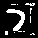

In [581]:
Image('manual.png', width=200, height=200)